In [115]:
pip install mediapipe

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [116]:
import os
import cv2
import glob
import warnings
import mediapipe
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
import scipy.io as sio
from pathlib import Path
from math import cos, sin

%matplotlib inline
warnings.filterwarnings('ignore')

In [117]:
# !wget http://www.cbsr.ia.ac.cn/users/xiangyuzhu/projects/3DDFA/Database/AFLW2000-3D.zip
# !unzip AFLW2000-3D.zip

In [118]:
def get_pyr_from_mat(mat_path):
    # Get yaw, pitch, roll from .mat annotation.
    # They are in radians
    mat = sio.loadmat(mat_path)
    # [pitch yaw roll tdx tdy tdz scale_factor]
    pre_pose_params = mat['Pose_Para'][0]
    # Get [pitch, yaw, roll]
    pose_params = pre_pose_params[:3]
    return pose_params

In [119]:
def draw_axis(img, pitch, yaw, roll, tdx=None, tdy=None, size = 100):
    # this function take image and return image with drawn pitch, yaw and roll axes on it.
    # input: 
    #     - img: image itself,
    #     - pitch: pitch value to be drawn as axis,
    #     - yaw: yaw value to be drawn as axis,
    #     - roll: roll value to be drawn as axis,
    #     - tdx: point on x-axis draw axis from, if None it sclect point in the moddle of the image,
    #     - tdy: point on y-axis draw axis from, if None it sclect point in the moddle of the image,
    #     - size: the lenght of axis in pixles.
    # output:
    #     - image with drawn pitch, yaw and roll axes on it.

    yaw = -yaw

    if tdx != None and tdy != None:
        pass

    else:
        height, width = img.shape[:2]
        tdx = width / 2
        tdy = height / 2

    # X-Axis pointing to right. drawn in red
    x1 = size * (cos(yaw) * cos(roll)) + tdx
    y1 = size * (cos(pitch) * sin(roll) + cos(roll) * sin(pitch) * sin(yaw)) + tdy

    # Y-Axis | drawn in green
    #        v
    x2 = size * (-cos(yaw) * sin(roll)) + tdx
    y2 = size * (cos(pitch) * cos(roll) - sin(pitch) * sin(yaw) * sin(roll)) + tdy

    # Z-Axis (out of the screen) drawn in blue
    x3 = size * (sin(yaw)) + tdx
    y3 = size * (-cos(yaw) * sin(pitch)) + tdy
    
    
    cv2.line(img, (int(tdx), int(tdy)), (int(x1),int(y1)),(0,0,255),2)
    cv2.line(img, (int(tdx), int(tdy)), (int(x2),int(y2)),(0,255,0),2)
    cv2.line(img, (int(tdx), int(tdy)), (int(x3),int(y3)),(255,0,0),2)
    

    return img

In [ ]:
mylist = [Path(f).stem for f in glob.glob("AFLW2000/*.mat")]
random_number = 22

In [121]:
def get_pt2d_from_img(img_name, relative_path = True, frame = False):
    # this function get each point on the face x,y 468 * 2 to get 936 features per face.
    # input: 
    #     - img_name: file name or image itself decided which using the next inputs as default is image name with relative path
    #     - relative_path: default value is True, if False it take the whole pass from the user
    #     - frame: override the previous flag if Ture deals as image or frame from video
    # output:
    #     - numpy array of tuple for each point on the face.
    
    x_points = []
    y_points = []
    faceModule = mediapipe.solutions.face_mesh
    with faceModule.FaceMesh(static_image_mode=True) as faces:
        # loading the image
        if frame:
            image = img_name
        elif relative_path :
            image = cv2.imread('AFLW2000/'+img_name+'.jpg')
        else:
            image = cv2.imread(img_name)
        # processing the face to extract the landmark points (468 point) for each x,y,z
        results = faces.process(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
        if results.multi_face_landmarks: 
          # looping over the faces in the image
          for face in results.multi_face_landmarks:

            for landmark in face.landmark:
                x = landmark.x
                y = landmark.y
                # note: the x and y values are scaled to the their width and height so we will get back their actual value in the image
                shape = image.shape 
                relative_x = int(x * shape[1])
                relative_y = int(y * shape[0])
                x_points.append(relative_x)
                y_points.append(relative_y)
                
    return(np.array([x_points,y_points]))  

In [123]:
df = pd.DataFrame(columns=[['x'+str(i) for i in range(1, 469)] + ['y'+str(i) for i in range(1, 469)] + ['pitch', 'yaw', 'roll']])

for img_file in mylist:
    full_path = os.path.join('AFLW2000/', img_file)
    x_y_list = get_pt2d_from_img(img_file)
    
    xs = x_y_list[0]
    ys = x_y_list[1]
    if len(xs):
        r = ys[7] - ys[1]
        xs = (xs - xs[1]) / r
        ys = (ys - ys[1]) / r
        pyr = get_pyr_from_mat(full_path)
    
        df = df.append(
            pd.DataFrame(
                np.append(xs, np.append(ys, pyr ,axis=0),axis=0).reshape(1,-1),
                columns=df.columns),
            ignore_index=True)
    else:
        pass
df.to_csv('Point_Results.csv')

In [124]:
pitch = df['pitch']
yaw = df['yaw']
roll = df['roll']
# pitch,yaw,roll

In [125]:
pitch_X_train, pitch_X_test, pitch_y_train, pitch_y_test = train_test_split(x, pitch, test_size=0.2,random_state=42)

xg_pitch = XGBRegressor(learning_rate=0.7, max_depth=1, n_estimators=13)
xg_pitch.fit(pitch_X_train, pitch_y_train)
print("Train Error: ",mean_absolute_error(xg_pitch.predict(pitch_X_train),pitch_y_train))
print('R2 Score: ',xg_pitch.score(pitch_X_train, pitch_y_train))
print("Validation Error: ",mean_absolute_error(xg_pitch.predict(pitch_X_test),pitch_y_test))
print('R2 Score: ',xg_pitch.score(pitch_X_test, pitch_y_test))

[16:43:31] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Train Error:  0.1497312952829748
R2 Score:  0.6191689981812767
Validation Error:  0.1446511319680315
R2 Score:  -0.964141431789014


In [126]:
yaw_X_train, yaw_X_test, yaw_y_train, yaw_y_test = train_test_split(x, yaw, test_size=0.2,random_state=42)

xg_yaw = XGBRegressor(random_state=0,verbosity = 0 , eta = 0.7 , n_estimators= 10 , max_depth=5)
xg_yaw.fit(yaw_X_train, yaw_y_train)
print("Train Error: ",mean_absolute_error(xg_yaw.predict(yaw_X_train),yaw_y_train))
print('R2 Score: ',xg_pitch.score(yaw_X_train, yaw_y_train))
print("Validation Error: ",mean_absolute_error(xg_yaw.predict(yaw_X_test),yaw_y_test))
print('R2 Score: ',xg_pitch.score(yaw_X_test, yaw_y_test))

Train Error:  0.23070564605152155
R2 Score:  -0.061045636296934935
Validation Error:  0.21621732375361125
R2 Score:  -0.4892394818357766


In [127]:
roll_X_train, roll_X_test, roll_y_train, roll_y_test = train_test_split(x, roll, test_size=0.2,random_state=42)

xg_roll = XGBRegressor(random_state=0,verbosity = 0 , eta = 0.7 , n_estimators= 10 , max_depth=5)
xg_roll.fit(roll_X_train, roll_y_train)
print("Train Error: ",mean_absolute_error(xg_roll.predict(roll_X_train),roll_y_train))
print('R2 Score: ',xg_pitch.score(roll_X_train, roll_y_train))
print("Validation Error: ",mean_absolute_error(xg_roll.predict(roll_X_test),roll_y_test))
print('R2 Score: ',xg_pitch.score(roll_X_test, roll_y_test))

Train Error:  0.21899230897993577
R2 Score:  -0.08236267691911459
Validation Error:  0.23985397797775287
R2 Score:  -1.6428324516664015


In [128]:
def test_img(img_file,relative_path = False, frame = False):
    df = pd.DataFrame(columns=[['x'+str(i) for i in range(1, 469)] + ['y'+str(i) for i in range(1, 469)]])

    x_y_list = get_pt2d_from_img(img_file,relative_path,frame)
    temp_list  = x_y_list
    tdx,tdy = None, None
    xs = x_y_list[0]
    ys = x_y_list[1]

    if len(xs):
        divisor = ys[10] - ys[1]
        xs = (xs - xs[1]) / divisor
        ys = (ys - ys[1]) / divisor
  
        df = df.append(
            pd.DataFrame(
                np.append(xs,ys ,axis=0).reshape(1,-1),
                columns=df.columns),
            ignore_index=True)
        tdx,tdy = x_y_list[1][0], x_y_list[1][1]
        x_y_list = [x for x in zip(*temp_list)]
    else:
        pass
    
    return df,tdx,tdy,x_y_list

In [129]:
def predict_pyr(img_name, frame = False):
    data,tdx,tdy,x_y_list = test_img(img_name,frame = frame)
    if len(data) == 0 :
        pitch = 0
        yaw   = 0
        roll  = 0
    else:
        pitch = xg_pitch.predict(data)
        yaw   = xg_yaw.predict(data)
        roll  = xg_roll.predict(data)

    return( pitch, yaw, roll,x_y_list)

[0.1586006] [0.16550067] [0.1372185]


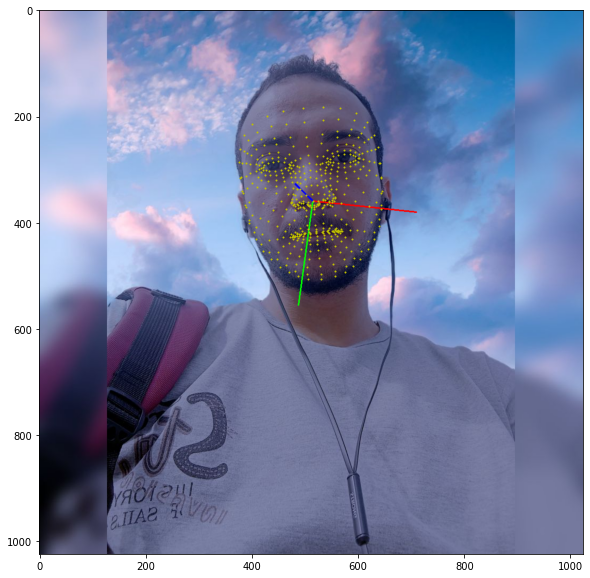

In [130]:
pitch, yaw, roll,x_y_list = predict_pyr('/content/Fantasy.jpg')
print(pitch, yaw, roll)

plt.figure(figsize=(10,10))

img = cv2.imread('/content/Fantasy.jpg')

img = draw_axis(img, pitch, yaw, roll, x_y_list[1][0], x_y_list[1][1], size = 200)
    
plt_img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)

for pt in x_y_list:
    plt.scatter(pt[0],pt[1],c = 'y',s = 1);
plt.imshow(plt_img);

In [131]:
video_path = "/content/drive/MyDrive/HeadPose.mp4"
filename = '/content/HeadPoseResult.mp4'


cap = cv2.VideoCapture(video_path)
frame_width = int(cap.get(3))
frame_height = int(cap.get(4))
out = cv2.VideoWriter(filename,cv2.VideoWriter_fourcc('M','J','P','G'), 30, (frame_width,frame_height))

while True:
    ret, frame = cap.read()
    if not ret:
      print("Can't receive frame (stream end?). Exiting ...")
      break 


    pitch, yaw, roll,x_y_list = predict_pyr(frame ,frame=True)

    img = draw_axis(frame, pitch , yaw, roll, x_y_list[1][0], x_y_list[1][1], size = 200)
    out.write(img) # write frame

    
    
        
# release and destroy windows
out.release()
cap.release()
cv2.destroyAllWindows()

Can't receive frame (stream end?). Exiting ...
